<a href="https://colab.research.google.com/github/xinruili07/MusicGenreClassifier/blob/master/CNN_Spectrogram_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!mkdir genres
!unzip -q "/content/genres.zip"

mkdir: cannot create directory ‘genres’: File exists


In [0]:
### Importing Libraries

import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt

import os
from PIL import Image
from pathlib import Path
import csv

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
import keras

In [0]:
import librosa.display

songname = f'./genres/blues/blues.00000.au'
y, sr = librosa.load(songname, mono=True, duration=2, offset=0)
ps = librosa.feature.melspectrogram(y=y, sr=sr, hop_length = 256, n_fft = 512, n_mels=128)
ps = librosa.power_to_db(ps**2)
ps.shape

(128, 173)

In [0]:
dataset = []
genres = {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 
        'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}

for genre, genre_number in genres.items():
    for filename in os.listdir(f'./genres/{genre}'):
        songname = f'./genres/{genre}/{filename}'
        for index in range(14):
            y, sr = librosa.load(songname, mono=True, duration=2, offset=index*2)
            ps = librosa.feature.melspectrogram(y=y, sr=sr, hop_length = 256, n_fft = 512, n_mels=64)
            ps = librosa.power_to_db(ps**2)
            dataset.append( (ps, genre_number) )               

In [0]:
print(len(dataset))

import random

random.shuffle(dataset)

train = dataset[:10000]
valid = dataset[10000:12000]
test = dataset[12000:]

X_train, Y_train = zip(*train)
X_valid, Y_valid = zip(*valid)
X_test, Y_test = zip(*test)

# Reshape for CNN input
X_train = np.array([x.reshape( (64, 173, 1) ) for x in X_train])
X_valid = np.array([x.reshape( (64, 173, 1) ) for x in X_valid])
X_test = np.array([x.reshape( (64, 173, 1) ) for x in X_test])

# One-Hot encoding for classes
Y_train = np.array(keras.utils.to_categorical(Y_train, 10))
Y_valid = np.array(keras.utils.to_categorical(Y_valid, 10))
Y_test = np.array(keras.utils.to_categorical(Y_test, 10))


14000


In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers import AveragePooling2D

from keras import regularizers

model = Sequential()
input_shape=(64, 173, 1)

model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))
model.add(AveragePooling2D((2, 2), strides=(2,2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="same"))
model.add(AveragePooling2D((2, 2), strides=(2,2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="same"))
model.add(AveragePooling2D((2, 2), strides=(2,2)))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 60, 169, 24)       624       
_________________________________________________________________
average_pooling2d_1 (Average (None, 30, 84, 24)        0         
_________________________________________________________________
activation_1 (Activation)    (None, 30, 84, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 84, 48)        28848     
_________________________________________________________________
average_pooling2d_2 (Average (None, 15, 42, 48)        0         
_________________________________________________________________
activation_2 (Activation)    (None, 15, 42, 48)        0         


In [0]:
from keras.callbacks import EarlyStopping

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=2)
hist = model.fit(X_train, Y_train, epochs=90, batch_size=32, validation_data= (X_valid, Y_valid), callbacks=[early_stopping])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 10000 samples, validate on 2000 samples
Epoch 1/90





10000/10000 [==============================] - 11s 1ms/step - loss: 2.0814 - acc: 0.2501 - val_loss: 1.6559 - val_acc: 0.4115
Epoch 2/90
10000/10000 [==============================] - 4s 366us/step - loss: 1.7175 - acc: 0.3801 - val_loss: 1.4679 - val_acc: 0.4905
Epoch 3/90
10000/10000 [==============================] - 4s 365us/step - loss: 1.5549 - acc: 0.4579 - val_loss: 1.2820 - val_acc: 0.5550
Epoch 4/90
10000/10000 [==============================] - 4s 371us/step - loss: 1.4417 - acc: 0.5013 - val_loss: 1.3244 - val_acc: 0.5485
Epoch 5/90
10000/10000 [==============================] - 4s 367us/step - loss: 1.3508 - acc: 0.5345 - val_loss: 1.2235 - val_acc: 0.5865
Epoch 6/90
10000/10000 [==============================] - 4s 362us/step - loss: 1.2843 - acc: 0.5590 - val_loss: 1.0796 - val_acc: 0.6395
Epoch 7/90
10000/100

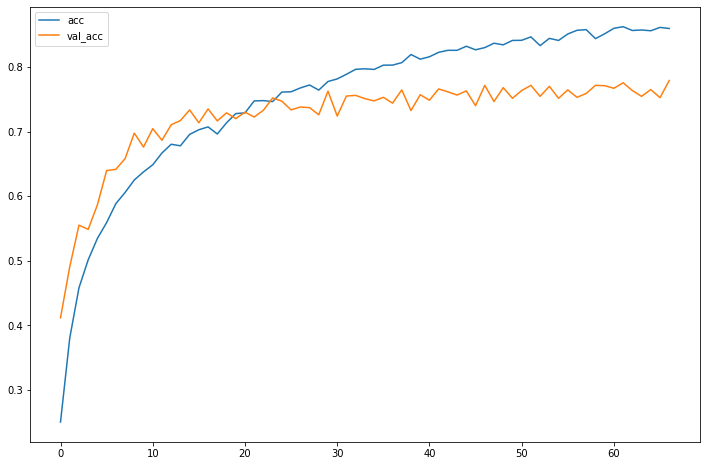

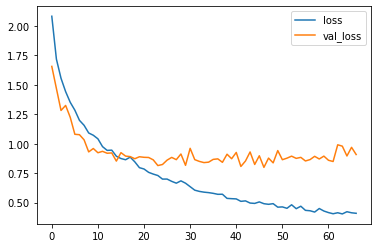

2000/2000 [==============================] - 0s 141us/step
Test loss: 0.9538973054885864
Test accuracy: 0.753


In [0]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['acc','val_acc'])
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.show()
score = model.evaluate(X_test, Y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

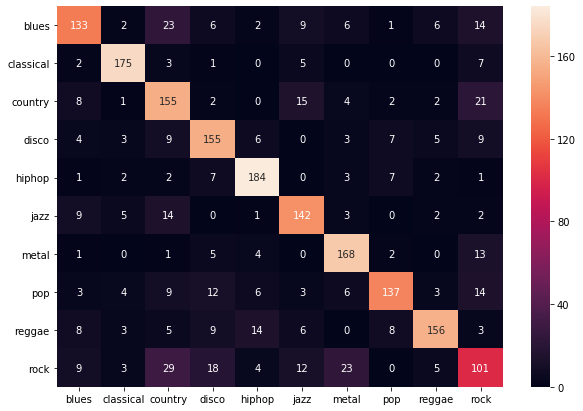



              precision    recall  f1-score   support

           0       0.75      0.66      0.70       202
           1       0.88      0.91      0.90       193
           2       0.62      0.74      0.67       210
           3       0.72      0.77      0.75       201
           4       0.83      0.88      0.86       209
           5       0.74      0.80      0.77       178
           6       0.78      0.87      0.82       194
           7       0.84      0.70      0.76       197
           8       0.86      0.74      0.79       212
           9       0.55      0.50      0.52       204

    accuracy                           0.75      2000
   macro avg       0.76      0.75      0.75      2000
weighted avg       0.76      0.75      0.75      2000



In [0]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn

y_pred = model.predict_classes(X_test)
Y_test = np.argmax(Y_test, axis=1)

con_mat = confusion_matrix(Y_test, y_pred)

plt.figure(figsize = (10,7))
ax = sn.heatmap(con_mat, annot=True, fmt="d", xticklabels=genres, yticklabels=genres)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.show()
print('\n')
print(classification_report(Y_test, y_pred))

In [0]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))